# LSTM1: Univariate LSTM model with prior one week’s data as the input

In [ ]:
import numpy as np
import pandas as pd
from keras.models import Sequential,Model
from keras.optimizers import Adam
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import time
import tensorflow as tf
from keras.layers import Input, LSTM, Dense, RepeatVector, TimeDistributed, concatenate

In [ ]:
data = pd.read_csv('imputed_dataset.csv')
train_data = pd.read_csv('training_data.csv')
test_data = pd.read_csv('testing_data.csv')

In [ ]:
train_data = train_data['Open'].values.reshape(-1, 1)
test_data = test_data['Open'].values.reshape(-1, 1)

In [ ]:
from scipy.stats import pearsonr

def pearson_correlation(actual, predicted):
    actual = actual * (data['Open'].max() - data['Open'].min()) + data['Open'].min()
    predicted = predicted *  (data['Open'].max() - data['Open'].min()) + data['Open'].min()
    correlation, _ = pearsonr(actual, predicted)
    return correlation

def evaluate_rmse_ratio(actual, predicted):
    actual = actual * (data['Open'].max() - data['Open'].min()) + data['Open'].min()
    predicted = predicted *  (data['Open'].max() - data['Open'].min()) + data['Open'].min()
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    return rmse

def calculate_rmse_per_day(y_true, y_pred):
    y_true = y_true * (data['Open'].max() - data['Open'].min()) + data['Open'].min()
    y_pred = y_pred *  (data['Open'].max() - data['Open'].min()) + data['Open'].min()
    rmse_per_day = []
    for i in range(5):
        rmse_per_day.append(np.sqrt(mean_squared_error(y_true[:, i], y_pred[:, i])))
    return rmse_per_day

In [ ]:
def create_dataset(data, time_steps=5, forecast_horizon=5):
    X, y = [], []
    for i in range(len(data) - time_steps - forecast_horizon + 1):
        X.append(data[i:(i + time_steps)])
        y.append(data[i + time_steps:i + time_steps + forecast_horizon].flatten())
    return np.array(X), np.array(y)

In [ ]:
X_train, y_train = create_dataset(train_data)
X_test, y_test = create_dataset(test_data)

In [ ]:
len(X_train)

1036

In [ ]:
rmse_list = []
execution_time_list = []
corr_list = []

In [ ]:
for i in range(10):
    start_time = time.time()

    first_model = Sequential()
    first_model.add(LSTM(200, activation='relu', input_shape=(5, 1)))
    first_model.add(Dense(200, activation='relu'))
    first_model.add(Dense(100, activation='relu'))
    first_model.add(Dense(5))

    first_model.compile(optimizer=Adam(), loss='mean_squared_error')

    history = first_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=0)

    predictions = first_model.predict(X_test)

    end_time = time.time()
    execution_time = end_time - start_time

    #RMSE on test data
    rmse = evaluate_rmse_ratio(y_test, predictions)
    rmse_list.append(rmse)

    #Execution time
    execution_time_list.append(execution_time)

    #RMSE per day
    rmse_per_day = calculate_rmse_per_day(y_test, predictions)

    #Correlation
    corr = pearson_correlation(y_test.flatten(), predictions.flatten())
    corr_list.append(corr)

    for j, item in enumerate(rmse_per_day):
        print(f'RMSE for day {j+2}: {item}')
    print(f"Round {i+1}: Loss = {history.history['loss'][-1]}, RMSE = {rmse}, Execution time = {execution_time}, Correlation = {corr}")

13/13 [==============================] - 0s 5ms/step
RMSE for day 2: 169.9942426419348
RMSE for day 3: 226.5642453164078
RMSE for day 4: 278.7098111490852
RMSE for day 5: 323.63171963175694
RMSE for day 6: 373.19076023835197
Round 1: Loss = 0.0006886305054649711, RMSE = 283.5198025172296, Execution time = 44.494160890579224, Correlation = 0.9603129277169082
13/13 [==============================] - 0s 7ms/step
RMSE for day 2: 197.08468532314578
RMSE for day 3: 240.62862237084994
RMSE for day 4: 296.57137460024916
RMSE for day 5: 334.37710026362004
RMSE for day 6: 388.4976230541017
Round 2: Loss = 0.0007345635094679892, RMSE = 299.1446257664315, Execution time = 43.19352674484253, Correlation = 0.9604902590087142
13/13 [==============================] - 0s 6ms/step
RMSE for day 2: 193.44683244011915
RMSE for day 3: 239.63931816930307
RMSE for day 4: 294.5242895579716
RMSE for day 5: 341.1679368034766
RMSE for day 6: 380.8476543099175
Round 3: Loss = 0.0006772734341211617, RMSE = 297.6688

In [ ]:
first_model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_9 (LSTM)               (None, 200)               161600    
                                                                 
 dense_27 (Dense)            (None, 200)               40200     
                                                                 
 dense_28 (Dense)            (None, 100)               20100     
                                                                 
 dense_29 (Dense)            (None, 5)                 505       
                                                                 
Total params: 222405 (868.77 KB)
Trainable params: 222405 (868.77 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
np.mean(rmse_list)/data['Open'].mean()

0.02994499142759586

In [ ]:
np.mean(execution_time_list)

39.18391087055206

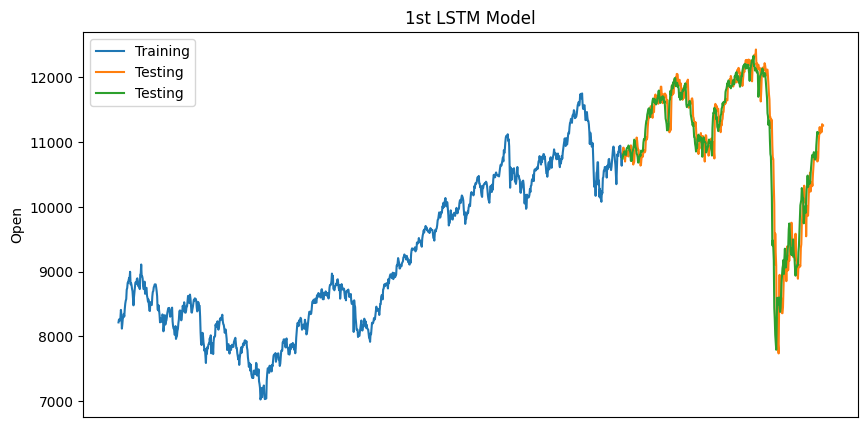

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.title("1st LSTM Model")
plt.plot(data['Date'][data['Date'] < '2018-12-28'], data['Open'][data['Date'] < '2018-12-28'], label = 'Training')
plt.plot(data['Date'][data['Date'] >= '2018-12-28'], data['Open'][data['Date'] >= '2018-12-28'], label = 'Testing')
plt.plot(data['Date'][(data['Date'] >= '2018-12-28') & (data['Date'] <= '2020-07-19')], predictions[:,0]*(data['Open'].max() - data['Open'].min()) + data['Open'].min(), label = 'Testing')

plt.xticks([])
plt.ylabel('Open')
plt.legend(loc = 'best')

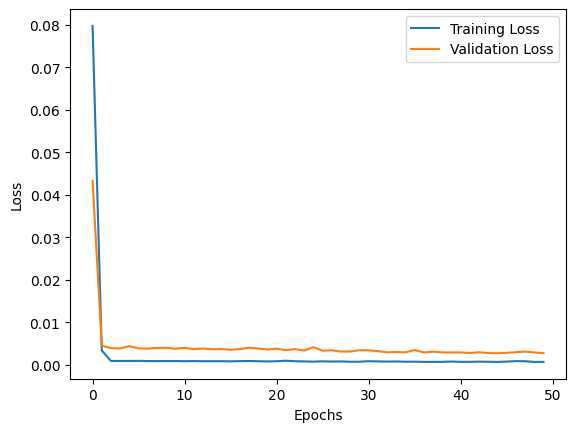

In [ ]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()